# Step by step guide for reconstruction of an image

Some introduction text about what to expect... Maybe some additional explanation where the data is located, or which packages are needed...

Import modules to load and process the data. Numpy handels data chrunching, h5py is responsible for file I/O

In [4]:
import os
import sys
sys.path.append('../')

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import rrsg_cgreco.linop as linop
import rrsg_cgreco.solver as solver
import rrsg_cgreco.recon as recon

from rrsg_cgreco._helper_fun import density_compensation
from rrsg_cgreco._helper_fun.est_coils import estimate_coil_sensitivities
from rrsg_cgreco._helper_fun.calckbkernel import calculate_keiser_bessel_kernel
from rrsg_cgreco._helper_fun.plotfun import plot_complex_arrows, plot_sequence

Solve a known problem in a difficult space...

The simplified signal equation tells us how image space and our acquired data are linked:

$$ \int p(\vec{r}) \exp{2\pi i r k} d\vec{r} = s(k).$$

Since we can discretize this equation, we can also write this as a matrix/vector problem

$$ Ax = b. $$

However, it might be so that A is an $n\times m$ matrix, or in any other way not invertible.
Multiplying both sides with its transpose gives

$$ A^TAx = A^Tb. $$

This does give us something to work with. But finding a solution will not be trivial, to
aid is in this endaveour, we find the help of the Conjugate Gradient method. This
allows us to iteratively find a solution $x$ to this problem.

Before we can continue with finding such solution. We first need to modify the data. It
is so that we have received raw k-space data that has been sample with a radial trajectory.
This causes the Fast Fourier Transform (FFT) to break down. There are possibilities to
perform a Non-Uniform Fast Fourier Transform, but it appears that an honest implementation
of this will be slow.
Thus we embark on a different route: we are going to regrid the radially acquired data to
a cartesian grid. The strategy we will use is by extrapolating our data to a cartesian grid
with the help of a special convolution kernel: the Keiser Bessel kernel.
In addition to that filter, we also need to correct for the density of the sample points with a
so called `density compensation function`.
After regridding and compensating for the trajectory sampling density, we also need to perform
an deapodization filter to compensation for the applied kernel. 

Let's start!

Read in data. The if/else for the heart is used to select the exact number of spokes as in the reference paper. Further we rotate and scale the loaded trajectory data.

In [21]:
path = '../../data/rawdata_brain_radial_96proj_12ch.h5'
import os
print(os.getcwd())
undersampling_factor = 1

# This gives us normalized trajectory over range -0.5 .. 0.5
rawdata, trajectory, noise_scan = recon.read_data(pathtofile=path, undersampling_factor=undersampling_factor)
print(f'Shape of the input data {rawdata.shape}')
print(f'\t Amount of coils: \t\t   {rawdata.shape[0]}')
print(f'\t Amount of acquisitions per coil:  {rawdata.shape[1]}')
print(f'\t Size of acquisition: \t\t   {rawdata.shape[2]}')
print(f'Shape of trajectory data {trajectory.shape}')
print(f'\t Amount of acquisitions per coil:  {trajectory.shape[0]}')
print(f'\t Size of acquisition: \t\t   {trajectory.shape[1]}')
print(f'\t Dimension of acquisition: \t   {trajectory.shape[2]}')

/home/bugger/PycharmProjects/rrsg_challenge_01/python/rrsg_cgreco
Shape of the input data (12, 96, 512)
	 Amount of coils: 		   12
	 Amount of acquisitions per coil:  96
	 Size of acquisition: 		   512
Shape of trajectory data (96, 512, 3)
	 Amount of acquisitions per coil:  96
	 Size of acquisition: 		   512
	 Dimension of acquisition: 	   3


To give you an idea what kind of data we just loaded, here a visual representation of the trajectory.

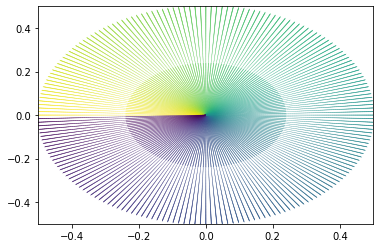

In [22]:
# Quiver plot of the trajectory. We only use the x, and y component now.
complex_trajectory = trajectory[:, :, 0] + 1j * trajectory[:, :, 1]
plot_complex_arrows(complex_trajectory);

The raw data contains data of all 12 coils, radially sampled. This pattern is clearly visible due to the bright band through the center.

amount of rows.. 1


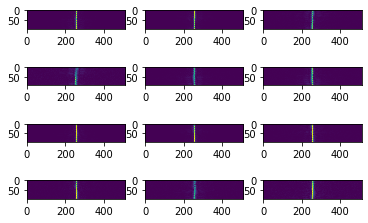

In [23]:
plot_sequence(rawdata[np.newaxis], augm='np.abs');

We will start by showing how one forward iteration of the regridding, deapidzation process looks like
 
First,define parameters for this process

In [24]:
num_coils, num_proj, num_reads = rawdata.shape
overgridfactor = 2  # over-gridding factor
num_scans = 1
num_slc = 1
dimX, dimY = (int(num_reads/overgridfactor),
              int(num_reads/overgridfactor))  # Hoe en waar worden dimX en dimY gebruikt?

DTYPE = np.complex64
DTYPE_real = np.float32

# Put these data points in a dictionary, such that it can be passed around quite easily
par_key = ['num_slc', 'num_scans', 'dimX', 'dimY', 'num_coils', 'num_proj', 'num_reads', 'overgridfactor']
par_val = [num_slc, num_scans, dimX, dimY, num_coils, num_proj, num_reads, overgridfactor]
par = dict(zip(par_key, par_val))


Get the density compensation function based on the trajectory data 


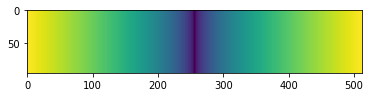

In [25]:
density_comp = (np.sqrt(np.array(density_compensation.get_golden_angle_dcf(trajectory), dtype=DTYPE_real)).astype(DTYPE_real))
density_comp = np.require(np.abs(density_comp), DTYPE_real, requirements='C')
plt.imshow(density_comp);

par['dens_cor'] = density_comp


Get Bessel Kernel for interpolation

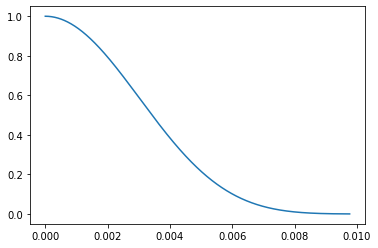

In [26]:

par['kwidth'] = 5
par['klength'] = 500
kerneltable, kerneltable_FT, u = calculate_keiser_bessel_kernel(G=256, **par)
plt.plot(u, kerneltable);


Get apodization 

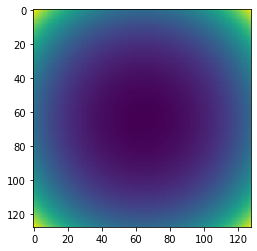

In [27]:
deapodization = 1 / kerneltable_FT.astype(DTYPE_real)
deapodization = np.outer(deapodization, deapodization)
plt.imshow(deapodization);


Now that you have seen all the individual models, we have combined these in a single class

In [28]:
# This creates a NUFFT object
import importlib
importlib.reload(linop)
# TODO make a check for which dimensions the trajectory variable should have
NUFFT = linop.NUFFT(par, trajectory, DTYPE=DTYPE, DTYPE_real=DTYPE_real)

# TODO make clear which dimensions to use!
ogkspace, grid_point_mapping = NUFFT._grid_lut(rawdata[None, :, None], return_mapping=True)

# To REALLY see how this mapping happened, check out this graph
# Here you see every point that is not equal to zero. We started with an intiialzied matrix of only zeros..
# So that means that you now see where the data has been.
plot_sequence((np.abs(ogkspace[0, 0:1, 0]) != 0).astype(int));

TypeError: __init__() got an unexpected keyword argument 'DTYPE'

What did this gridding exactly do? Well it created a mapping! 

it might be strange to see that the original is a rectangle, and the mapping circular.. but remember
that one row in the rectangle image represents one spoke of the circular pattern.

NameError: name 'grid_point_mapping' is not defined

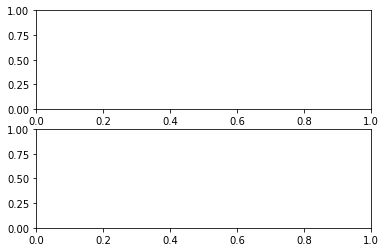

In [45]:

# This can take some time.. depending on n_step. Here we show how several spokes are being
# projected onto the cartesian grid with the help of the gridding kernel
fig, ax = plt.subplots(2)
len_traj = len(trajectory[0])
n_step = len_traj//4
import matplotlib.cm
cmap = matplotlib.cm.get_cmap('rainbow')

for jj in range(0, len_traj, n_step):
    for i_color, i_point in enumerate(range(jj * 512, (jj+1)*512, 32)):
        for i, temp_point in enumerate(grid_point_mapping[i_point]):
            if i == 0:
                # Original point
                ax[0].scatter(temp_point[0], temp_point[1], color=cmap(i_color + jj));
            else:
                # Mapped point
                ax[1].scatter(temp_point[0], temp_point[1], color=cmap(i_color + jj));

ax[0].set_title('Original');
ax[1].set_title('Mapping ');


And what is the result of the gridding to the original data...? 

In [ ]:
plot_sequence(rawdata[np.newaxis], augm='np.real', vmin=(0, 0.000001), ax_off=True);
plot_sequence(ogkspace[0:1, :, 0], augm='np.real', vmin=(0, 0.000001), ax_off=True);

Now let us add a Fourier Transform to it...

In [ ]:

ogkspace = np.fft.ifftshift(ogkspace, axes=NUFFT.fft_dim)
ogkspace = np.fft.ifft2(ogkspace, norm='ortho')
ogkspace = np.fft.ifftshift(ogkspace, axes=NUFFT.fft_dim)

plot_sequence(ogkspace[0:1, :, 0], augm='np.angle', title='no apodization - angle');
plot_sequence(ogkspace[0:1, :, 0], augm='np.abs', title='no apodization - abs');


...AND the apodization function

In [ ]:
ogkspace_deapo = NUFFT._deapo_adj(ogkspace)

plot_sequence(ogkspace_deapo[0:1, :, 0], augm='np.angle', title='with apodization - angle');
plot_sequence(ogkspace_deapo[0:1, :, 0], augm='np.abs', title='with apodization - abs');


Amazing! We moved stuff to a cartesian grid and got ourselves an image!
 
We have now seen how to move from k-space to image space with all the 
necessary steps involved with radially sampled data. 

However, we need to also take into account that different coils have a different 
view on the data. This is expressed in the coil sensitivity. There are various approaches
 on how to obtain this data. One of them is to apply the ESPIRIT algorithm as is done below. 
 

In [ ]:
# Compute the coil sensitivities
# This adds the 'coils' and 'phase_map' keys to the par dict.
estimate_coil_sensitivities(data=rawdata, trajectory=trajectory, par=par)


plot_sequence(par['coils'][np.newaxis, :, 0], augm='np.abs');
plot_sequence(par['phase_map'], augm='np.angle');


To combine also this (additional) coil information into an operator, and thus 
make it possible to do some multi coil solution solving, we create a new operator..

It has an augmented adjoint and forward operator, based on the `classic` NUFFT operation.
But now it included coil information

In [ ]:
MRImagingOperator = linop.MRIImagingModel(par, trajectory)

This operator will be used to solve the Ax=b equation..

In [ ]:
cgs = solver.CGReco(par)
cgs.set_operator(MRImagingOperator)

# Init variables
maxit = iters = 5
lambd = 1e-8
tol = 1e-5

guess = np.zeros(
                (maxit+1, 1, 1,
                par['num_slc'],
                par['dimY'],
                par['dimX']),
                dtype=DTYPE)
# We start with an initial guess of zero..
x = guess
data = rawdata * par["dens_cor"]
data = data[None, :, None, ...]  # Adjust for some dimensional stuff

b = cgs.operator_rhs(data)
# Looks decent
plt.imshow(np.abs(b[0, 0]))

residual = b
p = residual
delta = np.linalg.norm(residual) ** 2 / np.linalg.norm(b) ** 2
res_norm = []
res_norm.append(delta)

for i in range(iters):
    Ax = cgs.operator_lhs(p)
    Ax = Ax + lambd * p
    alpha = np.vdot(residual, residual) / (np.vdot(p, Ax))
    x[i + 1] = x[i] + alpha * p

    residual_new = residual - alpha * Ax
    delta = np.linalg.norm(residual_new) ** 2 / np.linalg.norm(b) ** 2
    res_norm.append(delta)
    if delta < tol:
        print("Converged after %i iterations to %1.3e." % (i + 1, delta))
        break

    if not np.mod(i, 1):
        print("Residuum at iter %i : %1.3e" % (i + 1, delta), end='\r')

    beta = (np.vdot(residual_new, residual_new) /
            np.vdot(residual, residual))
    p = residual_new + beta * p
    (residual, residual_new) = (residual_new, residual)


In [ ]:
plot_sequence(x[-1:, 0, 0, 0], augm='np.abs');

In [ ]:
plt.plot(res_norm)